In [1]:
# Install dependencies
!pip install torch torchvision torchaudio --quiet
!pip install transformers --quiet
!pip install pillow --quiet
!pip install ultralytics --quiet
!pip install num2words --quiet
print('done')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 10.0 MB/s eta 0:00:00
done


# CHECKING SmolVLM2

In [ ]:

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForImageTextToText
import requests
from io import BytesIO

# -------------------
# Device
# -------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# -------------------
# Load SmolVLM2
# -------------------
vlm_model_path = "HuggingFaceTB/SmolVLM2-256M-Video-Instruct"
processor = AutoProcessor.from_pretrained(vlm_model_path)
model_vlm = AutoModelForImageTextToText.from_pretrained(
    vlm_model_path,
    dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    _attn_implementation= "eager"
).to(device).eval()

# -------------------
# Sample images (URLs)
# -------------------
sample_urls = [
    "/content/boys_football.jpg",
    "/content/ppl sitting.jpg" ,
    "/content/dog_chasing_cat.png"
]

# -------------------
# Function to generate caption
# -------------------
def vlm_caption(image, prompt="Briefly describe this scene in natural language."):
    try:
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": prompt}
                ],
            }
        ]
        inputs = processor.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=True,
            return_tensors="pt",
            return_dict=True,
        ).to(model_vlm.device)

        generated_ids = model_vlm.generate(**inputs, max_new_tokens=50)
        response = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        return response
    except Exception as e:
        print(f"[Error]: {e}")
        return "Error analyzing image."

# -------------------
# Process sample images
# -------------------
for idx, filepath in enumerate(sample_urls):
    print(f"\nProcessing image {idx+1}: {filepath}")
    img = Image.open(filepath).convert("RGB")
    caption = vlm_caption(img)
    text = caption.split("Assistant:")[-1]
    print(f"SeeQ: {text}")


Using device: cuda


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]


Processing image 1: /content/boys_football.jpg
SeeQ:  A group of children playing soccer on a grassy field.

Processing image 2: /content/ppl sitting.jpg
SeeQ:  Two elderly women are sitting on a bench outdoors, enjoying a meal together.

Processing image 3: /content/dog_chasing_cat.png
SeeQ:  A gray dog with a red collar is chasing an orange cat.


In [ ]:
caption

'User:\n\n\nBriefly describe this scene in natural language.\nAssistant: A gray dog with a red collar is chasing an orange cat.'

In [ ]:
text

' A gray dog with a red collar is chasing an orange cat.'

# Checking YOLO11

In [ ]:
!pip install ultralytics --quiet
!pip install opencv-python-headless --quiet

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

Processing /content/boys_football.jpg...

image 1/1 /content/boys_football.jpg: 448x640 3 persons, 1 sports ball, 52.5ms
Speed: 15.9ms preprocess, 52.5ms inference, 57.3ms postprocess per image at shape (1, 3, 448, 640)
person: (47, 34), (108, 152)
sports ball: (85, 130), (112, 155)
person: (148, 22), (217, 145)
person: (111, 43), (190, 144)


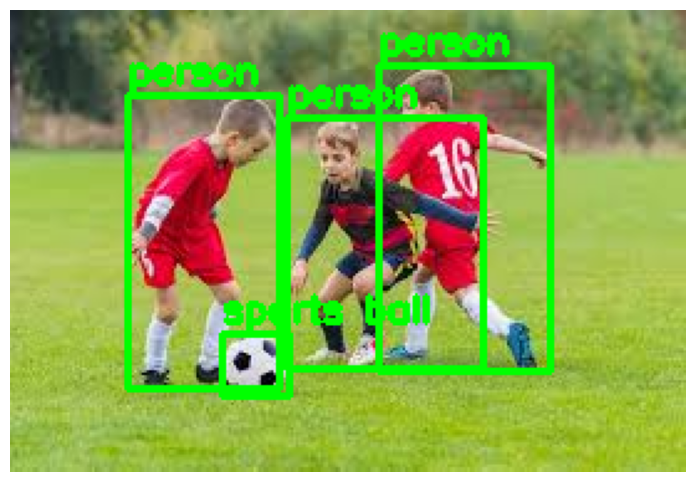


Processing /content/ppl sitting.jpg...

image 1/1 /content/ppl sitting.jpg: 320x640 2 persons, 85.2ms
Speed: 3.4ms preprocess, 85.2ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 640)
person: (122, 12), (220, 158)
person: (17, 6), (145, 158)


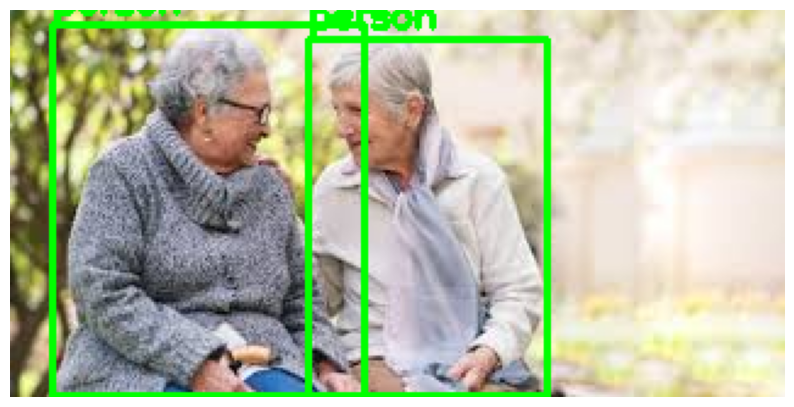


Processing /content/dog_chasing_cat.png...

image 1/1 /content/dog_chasing_cat.png: 320x640 1 kite, 14.4ms
Speed: 2.7ms preprocess, 14.4ms inference, 5.5ms postprocess per image at shape (1, 3, 320, 640)
kite: (187, 57), (310, 137)


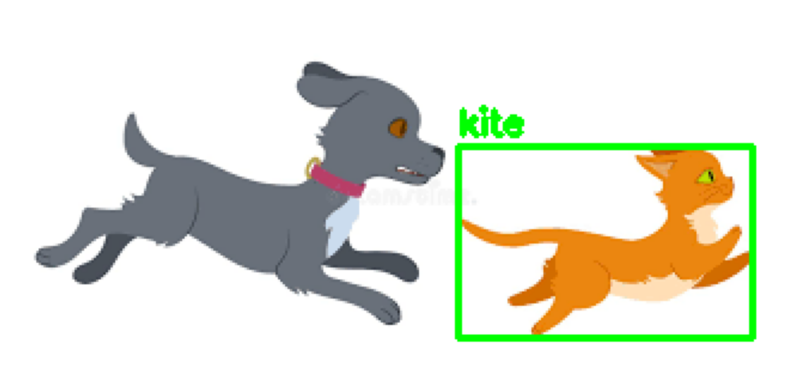

In [ ]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
from PIL import Image

# -------------------
# Load YOLO model
# -------------------
model = YOLO("/content/yolo11n.pt")  # replace with your YOLO model path

# -------------------
# Sample local images
# -------------------
image_files = [
    "/content/boys_football.jpg",
    "/content/ppl sitting.jpg",
    "/content/dog_chasing_cat.png"
]

# -------------------
# Run detection
# -------------------
for img_path in image_files:
    print(f"\nProcessing {img_path}...")
    results = model(img_path)  # runs detection
    result = results[0]        # first (and only) image

    # Print detected objects
    if len(result.boxes) > 0:
        for cls, box in zip(result.boxes.cls, result.boxes.xyxy):
            class_name = model.names[int(cls)]
            x1, y1, x2, y2 = map(int, box)
            print(f"{class_name}: ({x1}, {y1}), ({x2}, {y2})")
    else:
        print("No objects detected.")

    # Optional: display image with bounding boxes
    img = cv2.imread(img_path)
    for cls, box in zip(result.boxes.cls, result.boxes.xyxy):
        x1, y1, x2, y2 = map(int, box)
        label = model.names[int(cls)]
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

    # Convert BGR to RGB for displaying
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

# **YOLO + VLM comparision code**


Using device: cuda


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]


==================== Processing /content/boys_football.jpg ====================

[VLM Only]
A group of children playing soccer on a grassy field.

[YOLO Only]

image 1/1 /content/boys_football.jpg: 448x640 3 persons, 1 sports ball, 11.3ms
Speed: 1.7ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)
person at (47,34,108,152)
sports ball at (85,130,112,155)
person at (148,22,217,145)
person at (111,43,190,144)


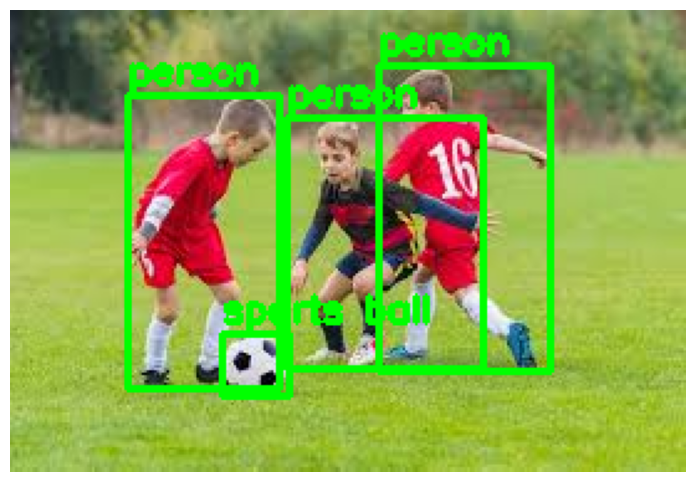


[YOLO + VLM]
A person is playing soccer on a grassy field. There are three children in the scene, with the person in the middle being the closest to the camera. The child on the left is wearing a red jersey with the number 16, and


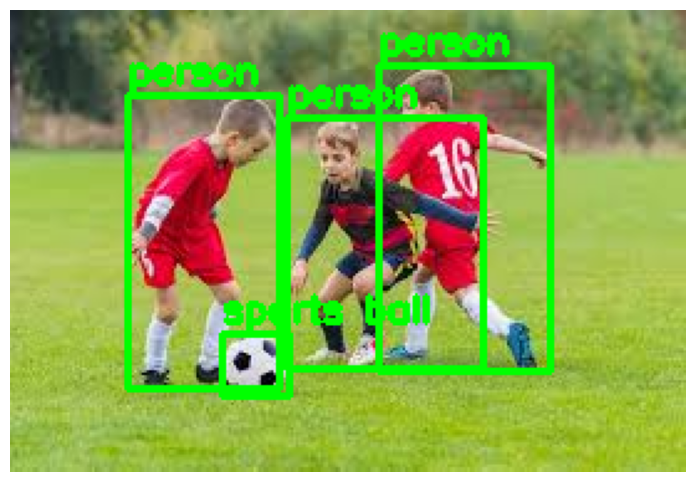


==================== Processing /content/ppl sitting.jpg ====================

[VLM Only]
Two elderly women are sitting on a bench outdoors, enjoying a meal together.

[YOLO Only]

image 1/1 /content/ppl sitting.jpg: 320x640 2 persons, 11.9ms
Speed: 2.6ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)
person at (122,12,220,158)
person at (17,6,145,158)


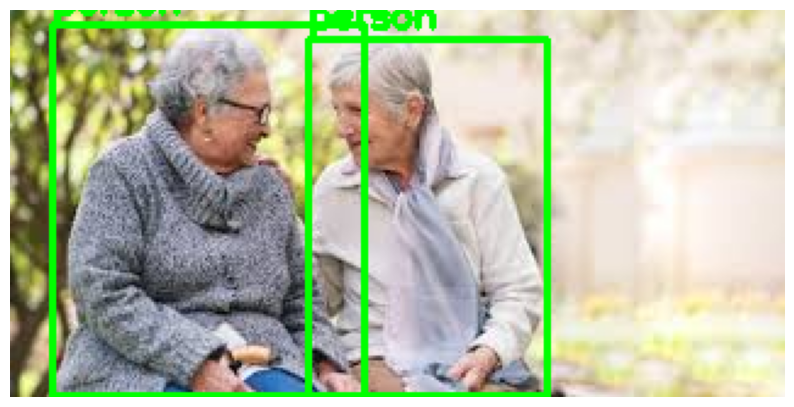


[YOLO + VLM]
Two elderly women are sitting on a bench in an outdoor setting. The woman on the left is wearing a gray sweater, while the woman on the right is wearing a light blue shirt. They are both holding plates of food, possibly a sandwich or


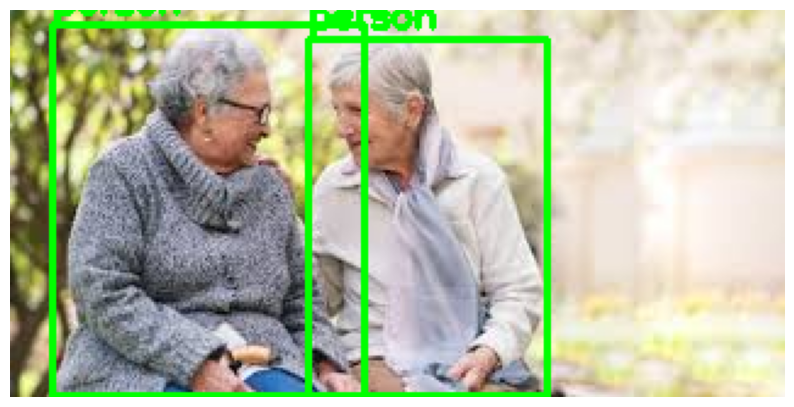


==================== Processing /content/dog_chasing_cat.png ====================

[VLM Only]
A gray dog with a red collar is chasing an orange cat.

[YOLO Only]

image 1/1 /content/dog_chasing_cat.png: 320x640 1 kite, 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)
kite at (187,57,310,137)


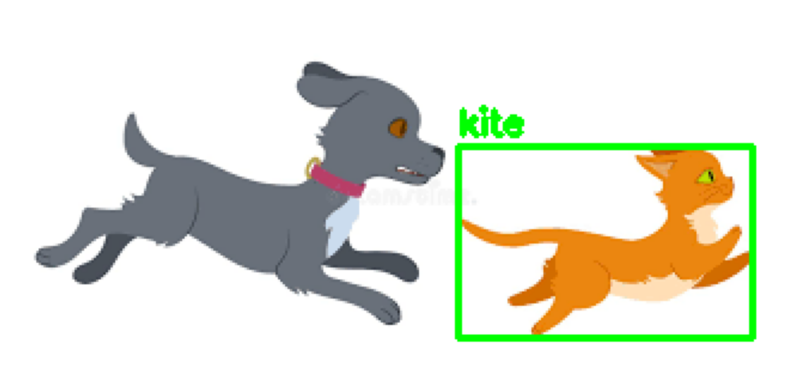


[YOLO + VLM]
A gray dog with a pink collar is running towards a brown and white cat.


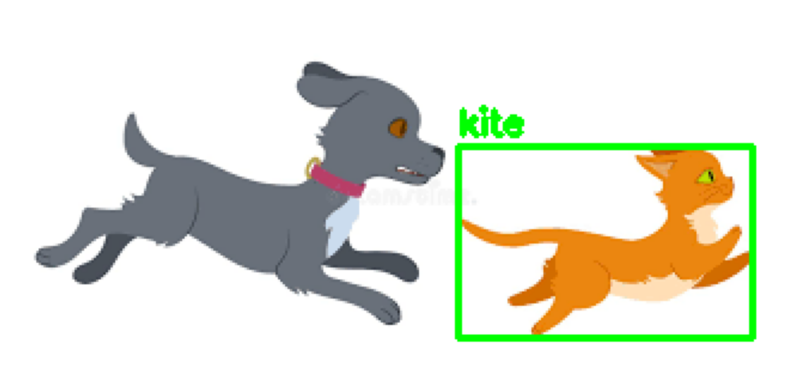

In [ ]:
# ------------------- Install dependencies if not done -------------------
# !pip install ultralytics --quiet
# !pip install transformers --quiet
# !pip install torch torchvision torchaudio --quiet
# !pip install pillow --quiet
# !pip install num2words --quiet

# ------------------- Imports -------------------
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForImageTextToText
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt

# ------------------- Device -------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ------------------- Load VLM -------------------
vlm_model_path = "HuggingFaceTB/SmolVLM2-256M-Video-Instruct"
processor = AutoProcessor.from_pretrained(vlm_model_path)
model_vlm = AutoModelForImageTextToText.from_pretrained(
    vlm_model_path,
    dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    _attn_implementation="eager"
).to(device).eval()

# ------------------- Load YOLO -------------------
yolo_model = YOLO("/content/yolo11n.pt")  # replace with your YOLO model path

# ------------------- Sample images -------------------
image_files = [
    "/content/boys_football.jpg",
    "/content/ppl sitting.jpg",
    "/content/dog_chasing_cat.png"
]

# ------------------- Helper functions -------------------
def vlm_caption(image, prompt="Briefly describe this scene in natural language."):
    try:
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": prompt}
                ],
            }
        ]
        inputs = processor.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=True,
            return_tensors="pt",
            return_dict=True,
        ).to(model_vlm.device)

        generated_ids = model_vlm.generate(**inputs, max_new_tokens=50)
        response = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        if "Assistant:" in response:
            response = response.split("Assistant:")[-1].strip()
        return response
    except Exception as e:
        print(f"[VLM Error]: {e}")
        return "Error analyzing image."

def yolo_detect(image_path):
    """Run YOLO detection and return a list of detected objects with bounding boxes"""
    results = yolo_model(image_path)
    result = results[0]
    objects_info = []

    if len(result.boxes) > 0:
        for cls, box in zip(result.boxes.cls, result.boxes.xyxy):
            class_name = yolo_model.names[int(cls)]
            x1, y1, x2, y2 = map(int, box)
            objects_info.append(f"{class_name} at ({x1},{y1},{x2},{y2})")
    return objects_info, result.boxes.xyxy, result.boxes.cls

def display_yolo_boxes(img_path, boxes, classes):
    """Display image with YOLO bounding boxes"""
    img_cv = cv2.imread(img_path)
    for box, cls in zip(boxes, classes):
        x1, y1, x2, y2 = map(int, box)
        label = yolo_model.names[int(cls)]
        cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img_cv, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

# ------------------- Main processing -------------------
for img_path in image_files:
    print(f"\n==================== Processing {img_path} ====================")

    # Load image
    img = Image.open(img_path).convert("RGB")

    # 1️⃣ VLM only
    print("\n[VLM Only]")
    caption_only = vlm_caption(img)
    print(caption_only)

    # 2️⃣ YOLO only
    print("\n[YOLO Only]")
    objects_info, boxes, classes = yolo_detect(img_path)
    if objects_info:
        for obj in objects_info:
            print(obj)
        display_yolo_boxes(img_path, boxes, classes)  # display image with YOLO boxes
    else:
        print("No objects detected.")

    # 3️⃣ YOLO + VLM
    print("\n[YOLO + VLM]")
    if objects_info:
        objects_text = "; ".join(objects_info)
        prompt_text = f"Objects detected: {objects_text}. Briefly describe the scene using these objects and their positions."
    else:
        prompt_text = "Briefly describe the scene in natural language."

    caption_yolo_vlm = vlm_caption(img, prompt=prompt_text)
    print(caption_yolo_vlm)

    # Display YOLO + VLM image (same as YOLO only, since bounding boxes are same)
    if objects_info:
        display_yolo_boxes(img_path, boxes, classes)


# actual pipeline

In [ ]:
# Install dependencies
!pip install torch torchvision torchaudio --quiet
!pip install transformers --quiet
!pip install pillow --quiet
!pip install ultralytics --quiet
!pip install num2words --quiet
print('done')

done


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/868 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]


==================== Processing /content/boys_football.jpg ====================

image 1/1 /content/boys_football.jpg: 448x640 3 persons, 1 sports ball, 47.2ms
Speed: 15.7ms preprocess, 47.2ms inference, 302.4ms postprocess per image at shape (1, 3, 448, 640)

Objects detected by YOLO:
person at (47, 34, 108, 152)
sports ball at (85, 130, 112, 155)
person at (148, 22, 217, 145)
person at (111, 43, 190, 144)


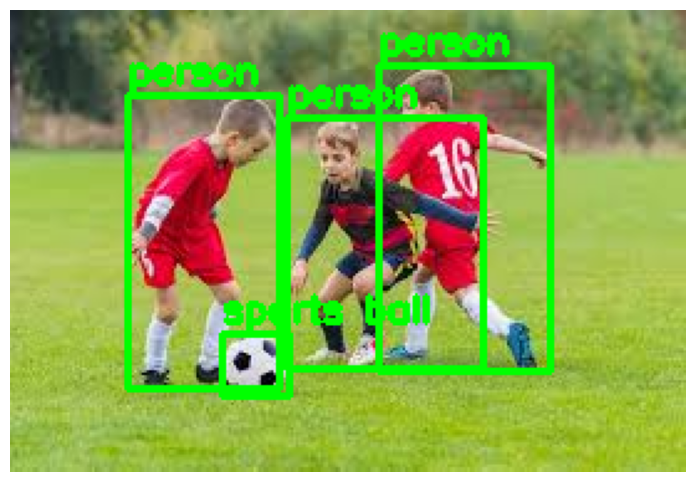


[YOLO + VLM Spatial Caption]:
In the image, there are three children playing soccer on a grassy field. The child in the foreground is wearing a red jersey with the number 16, while the other two are wearing red jerseys with the numbers 10 and 13. The child in the foreground is in a dynamic position, with one foot on the soccer ball and the other foot on the ground.

==================== Processing /content/ppl sitting.jpg ====================

image 1/1 /content/ppl sitting.jpg: 320x640 2 persons, 53.2ms
Speed: 2.1ms preprocess, 53.2ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)

Objects detected by YOLO:
person at (122, 12, 220, 158)
person at (17, 6, 145, 158)


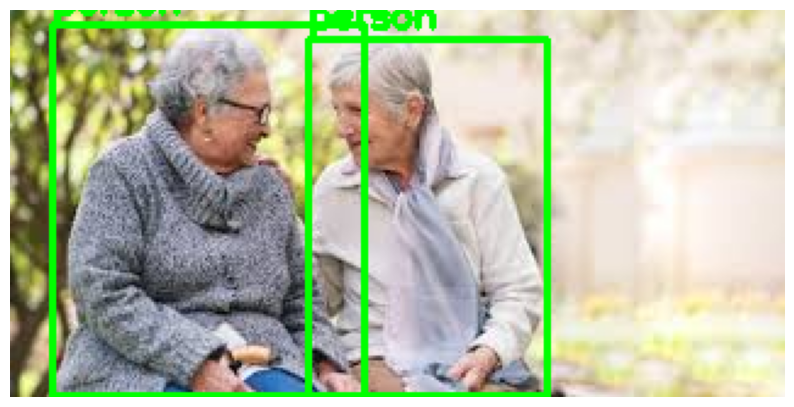


[YOLO + VLM Spatial Caption]:
The person is sitting on a bench, the person is sitting on the bench, and the person is sitting on the bench.

==================== Processing /content/dog_chasing_cat.png ====================

image 1/1 /content/dog_chasing_cat.png: 320x640 1 kite, 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 5.3ms postprocess per image at shape (1, 3, 320, 640)

Objects detected by YOLO:
kite at (187, 57, 310, 137)


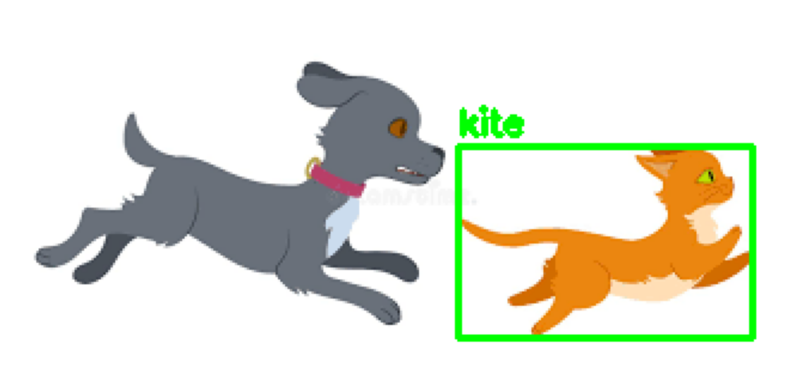


[YOLO + VLM Spatial Caption]:
The kite is in the foreground, the dog is in the middle, and the cat is in the background.


In [2]:

# ------------------- Imports -------------------
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForImageTextToText
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt

# ------------------- Device -------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ------------------- Load SmolVLM2 -------------------
vlm_model_path = "HuggingFaceTB/SmolVLM2-256M-Video-Instruct"
processor = AutoProcessor.from_pretrained(vlm_model_path)
model_vlm = AutoModelForImageTextToText.from_pretrained(
    vlm_model_path,
    dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    _attn_implementation="eager"
).to(device).eval()

# ------------------- Load YOLO -------------------
yolo_model = YOLO("/content/yolo11n.pt")  # replace with your YOLO model path

# ------------------- Sample images -------------------
image_files = [
    "/content/boys_football.jpg",
    "/content/ppl sitting.jpg",
    "/content/dog_chasing_cat.png"
]

# ------------------- Helper functions -------------------
def yolo_detect(image_path):
    """Run YOLO detection and return objects with bounding boxes"""
    results = yolo_model(image_path)
    result = results[0]
    objects_info = []

    if len(result.boxes) > 0:
        for cls, box in zip(result.boxes.cls, result.boxes.xyxy):
            class_name = yolo_model.names[int(cls)]
            x1, y1, x2, y2 = map(int, box)
            objects_info.append({"name": class_name, "box": (x1, y1, x2, y2)})
    return objects_info

def display_yolo_boxes(img_path, objects):
    """Display image with YOLO bounding boxes"""
    img_cv = cv2.imread(img_path)
    for obj in objects:
        x1, y1, x2, y2 = obj["box"]
        label = obj["name"]
        cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img_cv, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

def get_relative_positions(objects):
    """Compute relative positions between all pairs of objects"""
    relations = []
    for i in range(len(objects)):
        name_i, box_i = objects[i]["name"], objects[i]["box"]
        x1_i, y1_i, x2_i, y2_i = box_i
        cx_i, cy_i = (x1_i+x2_i)/2, (y1_i+y2_i)/2
        for j in range(len(objects)):
            if i == j: continue
            name_j, box_j = objects[j]["name"], objects[j]["box"]
            x1_j, y1_j, x2_j, y2_j = box_j
            cx_j, cy_j = (x1_j+x2_j)/2, (y1_j+y2_j)/2
            horiz = "left of" if cx_i < cx_j else "right of" if cx_i > cx_j else "aligned with"
            vert = "above" if cy_i < cy_j else "below" if cy_i > cy_j else "aligned with"
            relations.append(f"{name_i} is {horiz} {name_j} and {vert} {name_j}")
    return relations

def vlm_caption(image, prompt):
    """Generate caption from VLM"""
    try:
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": prompt}
                ],
            }
        ]
        inputs = processor.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=True,
            return_tensors="pt",
            return_dict=True,
        ).to(model_vlm.device)

        generated_ids = model_vlm.generate(**inputs, max_new_tokens=80)
        response = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        if "Assistant:" in response:
            response = response.split("Assistant:")[-1].strip()
        return response
    except Exception as e:
        print(f"[VLM Error]: {e}")
        return "Error analyzing image."

# ------------------- Main Processing -------------------
for img_path in image_files:
    print(f"\n==================== Processing {img_path} ====================")

    # Load image
    img = Image.open(img_path).convert("RGB")

    # 1️⃣ YOLO detection
    objects = yolo_detect(img_path)
    if objects:
        print("\nObjects detected by YOLO:")
        for obj in objects:
            print(f"{obj['name']} at {obj['box']}")
        display_yolo_boxes(img_path, objects)
    else:
        print("No objects detected.")

    # 2️⃣ Prepare YOLO -> VLM prompt with spatial relations
    if objects:
        objects_text = ", ".join([f"{obj['name']} at {obj['box']}" for obj in objects])
        relations = get_relative_positions(objects)
        relations_text = "; ".join(relations)
        prompt_text = (
            f"Objects detected: {objects_text}. "
            f"Include these relative positions: {relations_text}. "
            f"Describe the scene clearly for a visually impaired person."
        )
    else:
        prompt_text = "Briefly describe the scene in natural language for a visually impaired person."

    # 3️⃣ VLM caption with spatial awareness
    caption = vlm_caption(img, prompt_text)
    print("\n[YOLO + VLM Spatial Caption]:")
    print(caption)


# OCR test

In [4]:
!pip install paddlepaddle-gpu==3.0.0 -i https://www.paddlepaddle.org.cn/packages/stable/cu118/

Looking in indexes: https://www.paddlepaddle.org.cn/packages/stable/cu118/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 726.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.9/699.9 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 833.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 408.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!pip install paddleocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57

In [15]:
from paddleocr import PaddleOCR

ocr = PaddleOCR(
    use_doc_orientation_classify=False,
    use_doc_unwarping=False,
    use_textline_orientation=False,
)

result = ocr.predict("/content/ocr.jpg")
for res in result:
    res.print()
    res.save_to_img("output")
    res.save_to_json("output")

Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('PP-OCRv5_server_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-OCRv5_server_rec`.
{'res': {'input_path': '/content/ocr.jpg', 'page_index': None, 'model_settings': {'use_doc_preprocessor': True, 'use_textline_orientation': False}, 'doc_preprocessor_res': {'input_path': None, 'page_index': None, 'model_settings': {'use_doc_orientation_classify': False, 'use_doc_unwarping': False}, 'angle': -1}, 'dt_polys': array([[[20, 32],
        ...,
        [20, 57]]], dtype=int16), 'text_det_params': {'limit_side_len': 64, 'limit_type': 'min', 'thresh': 0.3, 'max_side_limit': 4000, 'box_thresh': 0.6, 'unclip_ratio': 1.5}, 'text_type': 'general', 'textline_orientation_angles': array([-1])

In [16]:
result[0]['rec_texts'][0]

'hey hello testing ocr'

# backend

In [ ]:
!pip install flask pyngrok pillow ultralytics transformers torch opencv-python matplotlib paddleocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 

In [ ]:
!pip install num2words

In [ ]:
pip install paddlepaddle-gpu==3.0.0 -i https://www.paddlepaddle.org.cn/packages/stable/cu118/

Looking in indexes: https://www.paddlepaddle.org.cn/packages/stable/cu118/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 565.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.9/699.9 MB 729.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [20]:
!pip install flask pyngrok pillow ultralytics transformers torch opencv-python matplotlib paddleocr

In [18]:

!pip install flask-cors

In [31]:
# ------------------- Installation & Imports for the Flask API -------------------
# You MUST run this cell first to install all necessary libraries.
# !pip install flask pyngrok pillow ultralytics transformers torch opencv-python matplotlib paddleocr
# !pip install --upgrade huggingface_hub # ensure huggingface_hub is up to date

import os
import io
import json
import tempfile
import sys
from flask import Flask, request, jsonify
from flask_cors import CORS
from werkzeug.utils import secure_filename
from pyngrok import ngrok
from PIL import Image, ImageDraw, ImageFont
import torch

# --- Import Colab-specific modules ---
try:
    from google.colab import userdata
    # For visualization in Colab
    from IPython.display import display, HTML
    import matplotlib.pyplot as plt
except ImportError:
    print("Warning: Running outside Colab. Visualization will be disabled.")
    def display_image_in_colab(img, title="Processed Image"): pass
    pass

# --- ML Model Imports ---
try:
    # Attempt to import all necessary ML libraries
    from transformers import AutoProcessor, AutoModelForImageTextToText
    from ultralytics import YOLO
    # Suppress PaddleOCR warnings/logs for cleaner output
    from paddleocr import PaddleOCR
    # Set up PaddleOCR logging to only show errors
    import logging
    logging.getLogger('ppocr').setLevel(logging.ERROR)
except ImportError:
    print("Warning: ML libraries not found. Ensure you run the pip install commands.")


# ------------------- Helper Function for Colab Visualization -------------------

def display_image_in_colab(img, title="Processed Image"):
    """Displays a PIL image in the Colab output using matplotlib."""
    if 'google.colab' not in sys.modules:
        return # Skip visualization if not in Colab

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# ------------------- Initialize Models and Device -------------------
print("Initializing models...")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Load SmolVLM2 ---
vlm_model_path = "HuggingFaceTB/SmolVLM2-256M-Video-Instruct"
try:
    processor = AutoProcessor.from_pretrained(vlm_model_path)
    model_vlm = AutoModelForImageTextToText.from_pretrained(
        vlm_model_path,
        # Use bfloat16 for speed on modern GPUs, fallback to float32
        dtype=torch.bfloat16 if device == "cuda" and torch.cuda.get_device_capability()[0] >= 8 else torch.float32,
        _attn_implementation="eager"
    ).to(device).eval()
    print("SmolVLM2 loaded.")
except Exception as e:
    print(f"Error loading SmolVLM2: {e}")
    model_vlm = None

# --- Load YOLO ---
yolo_model_path = "yolo11n.pt"
try:
    if not os.path.exists(yolo_model_path):
        print("Downloading YOLO11n model...")
        yolo_model = YOLO("yolo11n.pt")
    else:
        yolo_model = YOLO(yolo_model_path)
    print("YOLO model loaded.")
except Exception as e:
    print(f"Error loading YOLO: {e}")
    yolo_model = None

# --- Load PaddleOCR ---
print("Loading PaddleOCR...")
try:
    # Initialize OCR model with user-specified configuration
    ocr_model = PaddleOCR(use_angle_cls=True, lang="en")
    print("PaddleOCR loaded.")
except Exception as e:
    print(f"Error loading PaddleOCR: {e}")
    ocr_model = None


# ------------------- Helper Functions -------------------

def yolo_detect(img):
    """
    Run YOLO detection on a PIL Image and return objects with bounding boxes.
    Updated: Added explicit 'conf' parameter to increase detection robustness.
    """
    if not yolo_model: return []
    try:
        # Explicitly set confidence threshold to 0.4 for better detection robustness
        results = yolo_model.predict(img, verbose=False, conf=0.4)
        result = results[0]
        objects_info = []

        if len(result.boxes) > 0:
            for cls, box in zip(result.boxes.cls, result.boxes.xyxy):
                # FIX: Use .item() to safely extract the scalar class ID from the tensor slice.
                class_name = yolo_model.names[int(cls.item())]

                # FIX: Convert tensor box coordinates to a list of ints using list comprehension.
                x1, y1, x2, y2 = [int(coord) for coord in box.tolist()]

                objects_info.append({"name": class_name, "box": (x1, y1, x2, y2)})
            print(f"[DEBUG:YOLO] Detected {len(objects_info)} objects.")
        else:
            print("[DEBUG:YOLO] No objects detected.")
        return objects_info
    except Exception as e:
        print(f"[DEBUG:YOLO] Error during prediction: {e}")
        return []


def get_relative_positions(objects):
    """Compute relative positions between all pairs of objects"""
    relations = []
    for i in range(len(objects)):
        name_i, box_i = objects[i]["name"], objects[i]["box"]
        x1_i, y1_i, x2_i, y2_i = box_i
        cx_i, cy_i = (x1_i+x2_i)/2, (y1_i+y2_i)/2
        for j in range(len(objects)):
            if i == j: continue
            name_j, box_j = objects[j]["name"], objects[j]["box"]
            x1_j, y1_j, x2_j, y2_j = box_j
            cx_j, cy_j = (x1_j+x2_j)/2, (y1_j+y2_j)/2

            horiz = "left of" if cx_i < cx_j else "right of" if cx_i > cx_j else "horizontally aligned with"
            vert = "above" if cy_i < cy_j else "below" if cy_i > cy_j else "vertically aligned with"

            # Avoid redundant "aligned with" phrases
            if abs(cx_i - cx_j) < 50 and abs(cy_i - cy_j) < 50:
                relations.append(f"{name_i} is centered near {name_j}")
            elif horiz == "horizontally aligned with":
                relations.append(f"{name_i} is {vert} {name_j}")
            elif vert == "vertically aligned with":
                 relations.append(f"{name_i} is {horiz} {name_j}")
            else:
                relations.append(f"{name_i} is {horiz} and {vert} {name_j}")
    return relations[:10] # Limit output relations

def vlm_caption(image, prompt):
    """Generate caption from VLM"""
    if not model_vlm: return "VLM model is unavailable."
    print(f"[DEBUG:VLM] Starting caption generation with prompt: '{prompt[:50]}...'")
    try:
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": prompt}
                ],
            }
        ]
        inputs = processor.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=True,
            return_tensors="pt",
            return_dict=True,
        ).to(model_vlm.device)

        generated_ids = model_vlm.generate(**inputs, max_new_tokens=80)
        response = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        if "Assistant:" in response:
            response = response.split("Assistant:")[-1].strip()
        print(f"[DEBUG:VLM] Caption generated successfully.")
        return response
    except Exception as e:
        print(f"[VLM Error]: {e}")
        return "Error analyzing image."

# ------------------- Flask Application -------------------
app = Flask(__name__)
CORS(app) # Enable CORS for all routes

@app.route('/vlm', methods=['POST'])
def process_vlm():
    print("--- INCOMING REQUEST: /vlm (Automatic Capture) ---")
    if not model_vlm or not yolo_model:
        print("[ERROR:VLM] VLM or YOLO model not loaded. Returning 503.")
        return jsonify({"caption": "VLM/YOLO models failed to load. Cannot process."}), 503

    if 'file' not in request.files:
        print("[ERROR:VLM] No file part found in request.")
        return jsonify({"error": "No file part provided. Ensure the key is 'file'."}), 400

    image_file = request.files['file']
    print(f"[DEBUG:VLM] Received file: {image_file.filename}")

    try:
        # Read the image file and convert to PIL Image object
        img_bytes = image_file.read()
        img = Image.open(io.BytesIO(img_bytes)).convert("RGB")

        # --- VISUALIZATION STEP 1: Display Original Image ---
        display_image_in_colab(img.copy(), "Original Image (VLM Mode)")

        print("[DEBUG:VLM] Image successfully loaded into PIL.")
    except Exception as e:
        print(f"[ERROR:VLM] Image read/format error: {e}")
        return jsonify({"error": "Invalid image format"}), 400

    # 1️⃣ YOLO detection
    objects = yolo_detect(img)

    # 2️⃣ Prepare YOLO -> VLM prompt with spatial relations

    # --- VISUALIZATION STEP 2: Annotate and Display YOLO Output ---
    if objects:
        annotated_img = img.copy()
        draw = ImageDraw.Draw(annotated_img)
        # Attempt to load a better font for visualization
        try:
            # Look for a common Colab font
            font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 30)
        except Exception:
            font = ImageFont.load_default()

        for obj in objects:
            class_name = obj['name']
            x1, y1, x2, y2 = obj['box']

            # Draw bounding box (using red for detection)
            draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

            # Add text label (slightly offset)
            text_pos = (x1, max(0, y1 - 35))
            draw.text(text_pos, class_name, fill="red", font=font)

        display_image_in_colab(annotated_img, f"YOLO Detection Output ({len(objects)} Objects)")

        # Build VLM prompt
        objects_text = ", ".join([obj['name'] for obj in objects])
        relations = get_relative_positions(objects)
        relations_text = "; ".join(relations)

        # Keep the prompt concise
        prompt_text = (
            f"Objects: {objects_text}. "
            f"Relations: {relations_text}. "
            f"Describe the scene for a visually impaired person in one concise sentence."
        )
    else:
        prompt_text = "Briefly describe the scene in natural language for a visually impaired person in one concise sentence."
        print("[DEBUG:VLM] No objects detected. Using generic VLM prompt.")


    # 3️⃣ VLM caption with spatial awareness
    caption = vlm_caption(img, prompt_text)
    print(f"[DEBUG:VLM] Final Caption: {caption}")
    print(f"[DEBUG:VLM] Prompt used: {prompt_text}")


    # 4️⃣ Return the results as a JSON object (Text only)
    return jsonify({
        "caption": caption,
        "yolo_objects": objects,
        "vlm_prompt": prompt_text
    })

@app.route('/ocr', methods=['POST'])
def process_ocr():
    """Route for OCR processing (Manual Capture) using PaddleOCR."""
    print("--- INCOMING REQUEST: /ocr (Manual Capture) ---")

    if not ocr_model:
        print("[ERROR:OCR] OCR model not loaded. Returning 503.")
        return jsonify({"caption": "OCR model failed to load. Cannot process."}), 503

    if 'file' not in request.files:
        print("[ERROR:OCR] No file part found in request.")
        return jsonify({"error": "No file part provided."}), 400

    image_file = request.files['file']
    print(f"[DEBUG:OCR] Received file: {image_file.filename}")

    temp_file_path = None
    full_text = ""
    ocr_texts = []

    try:
        # --- Read image and save temp file ---
        img_bytes = image_file.read()
        img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
        print("[DEBUG:OCR] Image successfully loaded into PIL.")

        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
            temp_file_path = tmp.name
            img.save(temp_file_path)
        print(f"[DEBUG:OCR] Image temporarily saved to: {temp_file_path}")

        # --- Run PaddleOCR ---
        result = ocr_model.ocr(temp_file_path)
        print(f"[DEBUG:OCR] Raw OCR result type: {type(result)}")

        # --- Extract Texts ---
        # PaddleOCR 2.x can return structured or nested output
        if isinstance(result, list) and len(result) > 0:
            # Case 1: PaddleOCR >= 2.7 structured dict output
            if isinstance(result[0], dict) and 'rec_texts' in result[0]:
                ocr_texts = result[0]['rec_texts']
                print(f"[DEBUG:OCR] Extracted {len(ocr_texts)} texts using dict format.")

            # Case 2: Legacy nested list format [[box, [text, conf]], ...]
            elif isinstance(result[0], list) and len(result[0]) > 0:
                page_result = result[0]
                for line_data in page_result:
                    if not (isinstance(line_data, list) and len(line_data) >= 2):
                        continue
                    text = line_data[1][0]
                    ocr_texts.append(text)
                print(f"[DEBUG:OCR] Extracted {len(ocr_texts)} texts using list format.")

        full_text = " ".join(ocr_texts).strip()
        caption = f"The text detected in the image is: {full_text or 'No text detected.'}"

    except Exception as e:
        print(f"[OCR Error]: {e}")
        caption = f"An error occurred during OCR processing: {e}"

    finally:
        if temp_file_path and os.path.exists(temp_file_path):
            os.remove(temp_file_path)
            print(f"[DEBUG:OCR] Cleaned up temporary file.")

    # --- Send response to frontend ---
    print("[OCR RESULTS :]",ocr_texts)
    print("[OCR RESULTS COMBINED:]",full_text)
    return jsonify({
        "caption": caption,
        "ocr_results": ocr_texts,     # ✅ list of detected text lines
        "ocr_result_combined": full_text
    })


# ------------------- Run Flask with ngrok -------------------
PORT = 5000

# --- NGROK AUTH TOKEN SETUP FOR COLAB SECRETS ---
# Check if running in Google Colab environment
if 'google.colab' in sys.modules:
    try:
        # The user specified the secret key name is 'ngork'
        NGROK_TOKEN = userdata.get('ngork')
        ngrok.set_auth_token(NGROK_TOKEN)
        print("ngrok authentication token loaded from Colab Secrets using key 'ngork'.")
    except Exception as e:
        print(f"Warning: Could not read ngrok token from Colab Secrets ('ngork' key).")
        print(f"If tunneling fails, please ensure the secret is set up correctly.")


# ------------------- Post-Load Status Check (Check this first!) -------------------
print("\n--- Model Load Summary (REQUIRED for 200 response) ---")
print(f"SmolVLM2 (VLM): {'LOADED' if model_vlm else 'FAILED'}")
print(f"YOLOv8n (Detection): {'LOADED' if yolo_model else 'FAILED'}")
# Note: Renamed ocr to ocr_model for consistency
print(f"PaddleOCR (OCR): {'LOADED' if ocr_model else 'FAILED'}")
print("--------------------------\n")

try:
    # Attempt to establish ngrok connection
    public_url = ngrok.connect(PORT)
    public_url_str = public_url.public_url
    print(f"\n* Flask app running on port {PORT}")
    print(f"* Public URL to access API: {public_url_str}")
    print(f"\n!!! IMPORTANT: USE THIS URL IN YOUR MOBILE APP'S BASE_FLASK_API_URL !!!")
    print(f"e.g., set BASE_FLASK_API_URL = '{public_url_str}' in App.jsx")

    # Start the Flask server. use_reloader=False is crucial for Colab/notebook environments.
    if __name__ == '__main__':
        app.run(port=PORT, debug=True, use_reloader=False)

except Exception as e:
    print(f"\n[NGROK/FLASK ERROR]: Could not start server. Ensure you have installed pyngrok and set up an authtoken if required.")
    print(f"Error details: {e}")


Initializing models...
Using device: cuda


/tmp/ipython-input-1360406998.py:93: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr_model = PaddleOCR(use_angle_cls=True, lang="en")
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.


SmolVLM2 loaded.
YOLO model loaded.
Loading PaddleOCR...


Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/en_PP-OCRv5_mobile_rec`.


PaddleOCR loaded.
ngrok authentication token loaded from Colab Secrets using key 'ngork'.

--- Model Load Summary (REQUIRED for 200 response) ---
SmolVLM2 (VLM): LOADED
YOLOv8n (Detection): LOADED
PaddleOCR (OCR): LOADED
--------------------------


* Flask app running on port 5000
* Public URL to access API: https://a6cc60ce8974.ngrok-free.app

!!! IMPORTANT: USE THIS URL IN YOUR MOBILE APP'S BASE_FLASK_API_URL !!!
e.g., set BASE_FLASK_API_URL = 'https://a6cc60ce8974.ngrok-free.app' in App.jsx
 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


--- INCOMING REQUEST: /ocr (Manual Capture) ---
[DEBUG:OCR] Received file: cf762492-e532-4708-bf67-345c33159ad3.jpg
[DEBUG:OCR] Image successfully loaded into PIL.
[DEBUG:OCR] Image temporarily saved to: /tmp/tmpvshhhcub.png


/tmp/ipython-input-1360406998.py:312: DeprecationWarning: Please use `predict` instead.
  result = ocr_model.ocr(temp_file_path)
INFO:werkzeug:127.0.0.1 - - [08/Oct/2025 16:01:05] "POST /ocr HTTP/1.1" 200 -


[DEBUG:OCR] Raw OCR result type: <class 'list'>
[DEBUG:OCR] Extracted 101 texts using dict format.
[DEBUG:OCR] Cleaned up temporary file.
[OCR RESULTS :] ['File Edit Selection View Go Run Terminal Help', 'frontend', 'Eait', 'Sereenshot 2025-10-08 193758.jpg', '"', 'e0n', '0', 'hey', 'hello testing', 'ocr', '247 x88 3.4 KB', '03', '4189', '49', 'LUG', '[manua', 'Anaiysis successtul!', '50', '**', 'testing', 'ocr', 's0', 'OERPRE', '0', 'R', 'Uses the expo-speech library to speak the given text.', 'LOG', '[manual]', 'Preparing', 'to process', 'LOG', '[manual]', "NoTE: Requires 'npx expo install expo-speech' to be installed.", 'Analysis', 'successful!', 'native', 'sture-handler', '1/---', 'TTS Import', '*/', 'om', 'expo-speech', '1', 'n', 'ii i', '54', 'const speakCaption = (text: string) => {', 'a', 'a', 'CAPTURE', 'INTERVAL', '10000;', '1!', '10', 'seconds', '55', '// stop any currently speaking utterance before starting a new one', 'H', '}', 'Dimensions.get(*win', '1/', 'API Endpo', '56

INFO:werkzeug:127.0.0.1 - - [08/Oct/2025 16:02:09] "POST /ocr HTTP/1.1" 200 -


[DEBUG:OCR] Raw OCR result type: <class 'list'>
[DEBUG:OCR] Extracted 3 texts using dict format.
[DEBUG:OCR] Cleaned up temporary file.
[OCR RESULTS :] ['4', '', '']
[OCR RESULTS COMBINED:] 4
--- INCOMING REQUEST: /ocr (Manual Capture) ---
[DEBUG:OCR] Received file: 563b8d6e-ccdf-4b42-b2c1-9261da7e30b1.jpg
[DEBUG:OCR] Image successfully loaded into PIL.
[DEBUG:OCR] Image temporarily saved to: /tmp/tmp6b84fud8.png


INFO:werkzeug:127.0.0.1 - - [08/Oct/2025 16:02:25] "POST /ocr HTTP/1.1" 200 -


[DEBUG:OCR] Raw OCR result type: <class 'list'>
[DEBUG:OCR] Extracted 0 texts using dict format.
[DEBUG:OCR] Cleaned up temporary file.
[OCR RESULTS :] []
[OCR RESULTS COMBINED:] 
